In [363]:
import pandas as pd
import numpy as np
import random
from datetime import datetime,timedelta
import seaborn as sns
import datetime as dt
import pytz

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [364]:
def kumpulaDataPre(data):
    data['Date'] = pd.to_datetime(dict(year=data.Year, month=data.Month, day=data.Day, hour=data.Hour, minute=data.Minute, second=data.Second))
    data.set_index('Date',inplace=True)
    data.drop(columns=['Year','Month','Day','Hour','Minute','Second'],inplace=True)
    
    data.rename(columns={'KUM_META.rmm':'rmm',
                      'KUM_META.wdir':'wind diretion',
                      'KUM_META.t':'temperature',
                      'KUM_META.rh':'relative humidity',
                      'KUM_META.pwd_visibility_1':'visibility',
                      'KUM_META.ws':'windspeed'
                     },inplace=True)
    

    return data

In [365]:
#meteorolgy data
Mdata=pd.read_csv('Mdata_10.02-10.23.csv')
Mdata=kumpulaDataPre(Mdata)
Mdata.drop(columns=['KUM_META.pwd_rmm'],inplace=True)

In [366]:
# bus cancelled Time data
folder='data/cancelled_route_data/'
busdata=[]
for file in os.listdir(folder):
    if '.json' in file:
        # print(folder+file)
        jsondata = pd.read_json(folder+file)
        df=pd.json_normalize(jsondata['data']['cancelledTripTimes'])
        df['scheduledDeparture'] = pd.to_timedelta(df['scheduledDeparture'], unit='s')
        df['serviceDay'] = pd.to_datetime(df['serviceDay'], unit='s', origin='unix', utc=True)
        df['serviceDay']=df['serviceDay'].dt.tz_convert(pytz.timezone('Europe/Bucharest'))
        df['scheduledDeparture'] = df['serviceDay'] + df['scheduledDeparture']
        df.drop(columns=['serviceDay'],inplace=True)
        busdata.append(df)

busCdata=pd.concat(busdata)
# Busdata['scheduledDeparture']=Busdata['scheduledDeparture'].round('H')
busCdata['scheduledDeparture'] = busCdata['scheduledDeparture'].dt.strftime('%Y-%m-%d %H:%M:%S')
busCdata.set_index('scheduledDeparture',inplace=True)

# busCdata.head()

In [367]:
# bus regular Time data
busRdata=pd.read_excel('bus_regular_times.xlsx')
busRdata['Departure time'] = busRdata['Departure time'].apply(lambda x: x.strftime('%H:%M:%S'))

In [404]:
# get the bus names
busnames=busRdata['Bus Name'].unique()

In [412]:
for i in range(busnames.shape[0]):
    print(busnames[i])
    # bus regular Time data reshape
    df=busRdata[busRdata['Bus Name']==busnames[i]]
    date_range = pd.date_range(start='2023-10-02', end='2023-10-23', freq='D')
    duplicated_data = []
    for date in date_range:
        duplicated_data.append(df.copy())
        duplicated_data[-1]['Departure time'] = date.strftime('%Y-%m-%d') + ' ' + duplicated_data[-1]['Departure time']
    BusRdata = pd.concat(duplicated_data, ignore_index=True)

    BusRdata.set_index('Departure time',inplace=True)
    BusCdata=busCdata[busCdata['trip.routeShortName'] == '500']

    #combine bus data
    Busdata=BusRdata.merge(BusCdata, left_index=True, right_index=True, how='outer')
    
    # bus data reshape
    Busdata['time']=pd.to_datetime(Busdata.index)
    Busdata['time']=Busdata['time'].round('H')
    Busdata.set_index('time',inplace=True)
    Busdata.loc[Busdata['Bus Name'] != busnames[i], 'Bus Name'] = busnames[i]
    Busdata.drop(columns=['trip.routeShortName'],inplace=True)

    Busdata.loc[Busdata['realtimeState'] != 'CANCELED', 'realtimeState'] = 1
    Busdata.loc[Busdata['realtimeState'] == 'CANCELED', 'realtimeState'] = 0
    
    features=Mdata.keys()
    alldata=Busdata.join(Mdata)
    
    # model building
    label_encoder = LabelEncoder()
    alldata['bus_canceled'] = label_encoder.fit_transform(alldata['realtimeState'])

    train_size = 0.8  # You can adjust this ratio
    split_index = int(len(alldata) * train_size)
    train_data = alldata[:split_index]
    test_data = alldata[split_index:]

    # Separate features and target variable
    X_train = train_data[features]
    y_train = train_data['bus_canceled']
    X_test = test_data[features]
    y_test = test_data['bus_canceled']

    # Model Training
    model = XGBClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Not Canceled', 'Canceled'])
    print(f"Accuracy: {accuracy:.2f}")
    # print(report)

500
Accuracy: 0.99
A
Accuracy: 0.99
71
Accuracy: 1.00
522
Accuracy: 0.99
520
Accuracy: 0.99
59
Accuracy: 1.00
510
Accuracy: 1.00
I
Accuracy: 1.00
118
Accuracy: 0.99
41
Accuracy: 1.00
K
Accuracy: 1.00


# Data Analysis

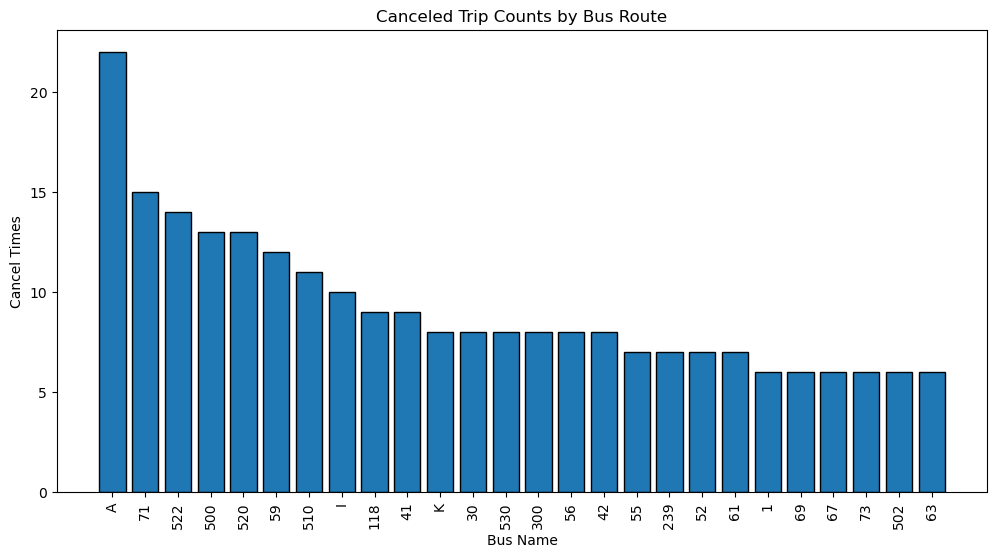

In [403]:
filtered_data = BUScanceltimes[BUScanceltimes['Canceltime'] > 5]
sorted_data = filtered_data.sort_values(by='Canceltime', ascending=False)

# Extract data for plotting
bus_names = sorted_data['Bus']
cancel_times = sorted_data['Canceltime']

# Create a bar plot
plt.figure(figsize=(12, 6))  # Optional: Set the figure size
plt.bar(bus_names, cancel_times, edgecolor='k')
plt.xlabel('Bus Name')
plt.ylabel('Cancel Times')
plt.title('Canceled Trip Counts by Bus Route')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
# plt.show()
plt.savefig('bus_cancel_times.png')


In [289]:
# Busdata.keys()
# Busdata[Busdata['trip.routeShortName']=='nan']
# Busdata['trip.route.longName'].unique()

Index(['Bus Name', 'realtimeState', 'headsign', 'trip.gtfsId',
       'trip.tripHeadsign', 'trip.routeShortName', 'trip.directionId',
       'trip.pattern.code', 'trip.pattern.name', 'trip.route.gtfsId',
       'trip.route.longName'],
      dtype='object')